# Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
import multiprocess as mp
from functools import partial

# Multiprocessing

In [2]:
def parallelize(data, func, num_of_processes=mp.cpu_count()):
    data_split = np.array_split(data, num_of_processes)
    pool = mp.Pool(num_of_processes)
    data = pd.concat(pool.map(func, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(func, data_subset):
    return data_subset.apply(func, axis=1)

def parallelize_on_rows(data, func, num_of_processes=8):
    return parallelize(data, partial(run_on_subset, func), num_of_processes)

# Data Import

The Data is provided by OptionMetric. To retreive the data for this notebook, please go to:
https://wrds-www.wharton.upenn.edu/pages/get-data/optionmetrics/ivy-db-us/options/option-prices/
and download the data for 2021/11/01.

Make the following configuration:

- Company Code: CBOE S&P 500 INDEX (Ticker: SPX)
- Option Type: Both
- Exercise Style: European
- Security Type: Index

Choose at least the following query variables:

- date
- exdate
- cp_flag
- strike_price
- best_bid
- best_offer
- impl_volatility

Then download the data as .csv.

In [3]:
df_option_prices = pd.read_csv('prices_01_11_2021.csv')

In [4]:
df_option_prices['tau_days'] = (pd.to_datetime(df_option_prices['exdate']) - pd.to_datetime(df_option_prices['date'])).dt.days
df_option_prices['tau_years'] = df_option_prices['tau_days'] / 365
df_option_prices['strike_price'] = df_option_prices['strike_price'] / 1000
df_option_prices['mid'] = np.average(df_option_prices[['best_bid', 'best_offer']], axis=1)

df_option_prices['S_t'] = 4_613.67
df_option_prices['r'] = 0.01300
df_option_prices['q'] = 0.0135

df_option_prices = df_option_prices.loc[(df_option_prices['tau_days'] > 0) & (df_option_prices['best_bid'] > 0) & (df_option_prices['best_offer'] > 0)]
df_option_prices = df_option_prices.sort_values(['tau_days', 'strike_price']).copy()

# 3.1.2 Volatility Surface Grid

$$\begin{split}
m_i = \exp \left( \log(m_1) + (i-1) \frac{\log(m_{20}) - \log(m_1)}{19} \right) \quad &\text{for} \; i=1, \dots, 20 \text{, and}\\
\tau_j = \exp \left( \log(\tau_1) + (j-1) \frac{\log(\tau_{20}) - \log(\tau_1)}{19} \right) \quad &\text{for} \; j=1, \dots, 20\text{.}
\end{split}$$

In [5]:
# Grid Range
log_tau_range = (np.log(30/365), np.log(1))
log_m_range = (np.log(0.6), np.log(1.4))

# Grid Number of Points
tau_n_points = 20
m_n_points = 20

# Grid Spacing
log_tau_spacing = (log_tau_range[1] - log_tau_range[0]) / (tau_n_points-1)
log_m_spacing = (log_m_range[1] - log_m_range[0]) / (m_n_points-1)

# Grid Vector
log_tau_grid_vec = np.linspace(log_tau_range[0] - log_tau_spacing * 1, log_tau_range[1] + log_tau_spacing * 1, tau_n_points + 2)
log_m_grid_vec = np.linspace(log_m_range[0] - log_m_spacing * 2, log_m_range[1] + log_m_spacing * 2, m_n_points + 4)

# 3.1.3 Estimating the Implied Interest Rate and Cash Dividend Yield Using Put-Call Parity

$$\min_{r_\tau, q_\tau} \frac{1}{N_\tau} \sum_{i=1}^{N_\tau} \left( (C_{i,\tau} - P_{i,\tau}) - \left( S e^{-q_\tau \tau} - K_{i,\tau} e^{-r_\tau \tau} \right) \right)^2 \quad \forall \tau \in \boldsymbol{\tau}$$

In [6]:
def implied_r_q(df_tau):
    df_tau_c = df_tau.loc[df_tau['cp_flag'] == 'C']
    df_tau_p = df_tau.loc[df_tau['cp_flag'] == 'P']
    
    k_vec = np.intersect1d(df_tau_c['strike_price'].unique(), df_tau_c['strike_price'].unique())
    
    index_c_vec = np.searchsorted(df_tau_c['strike_price'], k_vec)
    index_p_vec = np.searchsorted(df_tau_p['strike_price'], k_vec)
    
    c_vec = df_tau_c['mid'].values[index_c_vec]
    p_vec = df_tau_p['mid'].values[index_p_vec]
    
    s_t = df_tau['S_t'].iloc[0]
    tau = df_tau['tau_years'].iloc[0]
    
    r_init = df_tau['r'].iloc[0]
    q_init = df_tau['q'].iloc[0]
    
    def r_q_obj(x):
        r = x[0]
        q = x[1]
        return np.average(np.square((c_vec - p_vec) - (s_t * np.exp(-q * tau) - k_vec * np.exp(-r * tau))))
    
    r_q_result = minimize(r_q_obj, [r_init, q_init], method='BFGS', options={"disp": False, "maxiter": 500, "xrtol": 1e-5})
    
    r_hat = r_q_result.x[0]
    q_hat = r_q_result.x[1]
    
    return pd.Series([r_hat, q_hat])

In [7]:
df_option_prices[['r_hat', 'q_hat']] = df_option_prices.groupby('tau_days').apply(implied_r_q).loc[df_option_prices['tau_days'].values].values

In [8]:
df_option_prices['forward_tau'] = df_option_prices['S_t'] * np.exp((df_option_prices['r_hat'] - df_option_prices['q_hat']) * df_option_prices['tau_years'])
df_option_prices['moneyness'] = df_option_prices['strike_price'] / df_option_prices['forward_tau']

df_option_prices['log_moneyness'] = np.log(df_option_prices['moneyness'])
df_option_prices['log_tau_years'] = np.log(df_option_prices['tau_years'])

# 3.1.4 Black-Scholes-Merton-Implied Volatility

$$C_{BS}(S_t, K, \tau, r_{\tau}, q_{\tau}, \sigma) = e^{-q_{\tau} \tau}S_t \Phi(d_+) - e^{-r_{\tau} \tau} K \Phi(d_-)\text{,}$$

$$\text{with } d_{\pm} = \frac{\log(\frac{S_t}{K}) + (r_{\tau} - q_{\tau}) \tau}{\sigma \sqrt{\tau}} \pm \frac{\sigma \sqrt{\tau}}{2}$$

In [9]:
def black_scholes_call(sigma, S_t, K, tau, r, q):
    d_1 = (np.log(S_t / K) + (r - q + (sigma**2 / 2)) * tau) / (sigma * np.sqrt(tau))
    d_2 = d_1 - (sigma * np.sqrt(tau))
    return norm.cdf(d_1) * S_t * np.exp(-q * tau) - norm.cdf(d_2) * K * np.exp(-r * tau)

In [10]:
def black_scholes_put(sigma, S_t, K, tau, r, q):
    d_1 = (np.log(S_t / K) + (r - q + (sigma**2 / 2)) * tau) / (sigma * np.sqrt(tau))
    d_2 = d_1 - (sigma * np.sqrt(tau))
    return norm.cdf(-d_2) * K * np.exp(-r * tau) - norm.cdf(-d_1) * S_t * np.exp(-q * tau)

In [11]:
def implied_volatilitiy_call_of(sigma, S_t, K, tau, r, q, C):
    bsc = black_scholes_call(sigma[0], S_t, K, tau, r, q)
    of = C - bsc
    return of**2

In [12]:
def implied_volatilitiy_put_of(sigma, S_t, K, tau, r, q, P):
    bsp = black_scholes_put(sigma[0], S_t, K, tau, r, q)
    of = P - bsp
    return of**2

In [13]:
def implied_volatility(option_data_s):
    xrtol = 1e-6
    S_t = option_data_s['S_t']
    K = option_data_s['strike_price']
    tau = option_data_s['tau_years']
    r = option_data_s['r_hat']
    q = option_data_s['q_hat']
    bid = option_data_s['best_bid']
    offer = option_data_s['best_offer']
    mid = np.average((option_data_s['best_bid'], option_data_s['best_offer']))
    
    if (option_data_s['cp_flag'] == 'C'):
        result_bid = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r, q, bid), method='BFGS', options={"disp": False, "maxiter": 500, "xrtol": xrtol})
        result_offer = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r, q, offer), method='BFGS', options={"disp": False, "maxiter": 500, "xrtol": xrtol})
        result_mid = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r, q, mid), method='BFGS', options={"disp": False, "maxiter": 500, "xrtol": xrtol})
        
    if (option_data_s['cp_flag'] == 'P'):
        result_bid = minimize(implied_volatilitiy_put_of, 0.3, args=(S_t, K, tau, r, q, bid), method='BFGS', options={"disp": False, "maxiter": 500, "xrtol": xrtol})
        result_offer = minimize(implied_volatilitiy_put_of, 0.3, args=(S_t, K, tau, r, q, offer), method='BFGS', options={"disp": False, "maxiter": 500, "xrtol": xrtol})
        result_mid = minimize(implied_volatilitiy_put_of, 0.3, args=(S_t, K, tau, r, q, mid), method='BFGS', options={"disp": False, "maxiter": 500, "xrtol": xrtol})
    
    impl_vol_bid = result_bid.x[0] if result_bid.fun < 0.01 else np.nan
    impl_vol_offer = result_offer.x[0] if result_offer.fun < 0.01 else np.nan
    impl_vol_mid = result_mid.x[0] if result_mid.fun < 0.01 else np.nan
    
    return impl_vol_bid, impl_vol_offer, impl_vol_mid, result_mid.status, result_mid.x[0], result_mid.fun

In [14]:
def implied_volatility(option_data_s):
    xrtol = 1e-4
    obj_max = 1e-04
    
    S_t = option_data_s['S_t']
    K = option_data_s['strike_price']
    tau = option_data_s['tau_years']
    r = option_data_s['r_hat']
    q = option_data_s['q_hat']
    bid = option_data_s['best_bid']
    offer = option_data_s['best_offer']
    mid = np.average((option_data_s['best_bid'], option_data_s['best_offer']))
    
    if (option_data_s['cp_flag'] == 'C'):
        result_bid = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r, q, bid), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
        result_offer = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r, q, offer), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
        result_mid = minimize(implied_volatilitiy_call_of, 0.3, args=(S_t, K, tau, r, q, mid), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
        
    if (option_data_s['cp_flag'] == 'P'):
        result_bid = minimize(implied_volatilitiy_put_of, 0.3, args=(S_t, K, tau, r, q, bid), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
        result_offer = minimize(implied_volatilitiy_put_of, 0.3, args=(S_t, K, tau, r, q, offer), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
        result_mid = minimize(implied_volatilitiy_put_of, 0.3, args=(S_t, K, tau, r, q, mid), method='BFGS', options={"disp": False, "maxiter": 100, "xrtol": xrtol})
    
    impl_vol_bid = result_bid.x[0] if result_bid.fun < obj_max else np.nan
    impl_vol_offer = result_offer.x[0] if result_offer.fun < obj_max else np.nan
    impl_vol_mid = result_mid.x[0] if result_mid.fun < obj_max else np.nan
    
    return impl_vol_bid, impl_vol_offer, impl_vol_mid

In [15]:
df_option_prices[['impl_vol_bid', 'impl_vol_offer', 'impl_vol_mid']] = parallelize_on_rows(df_option_prices, implied_volatility).apply(pd.Series)

In [16]:
df_implied_vol = df_option_prices.dropna(subset=['impl_vol_bid', 'impl_vol_offer', 'impl_vol_mid'], axis=0).copy()

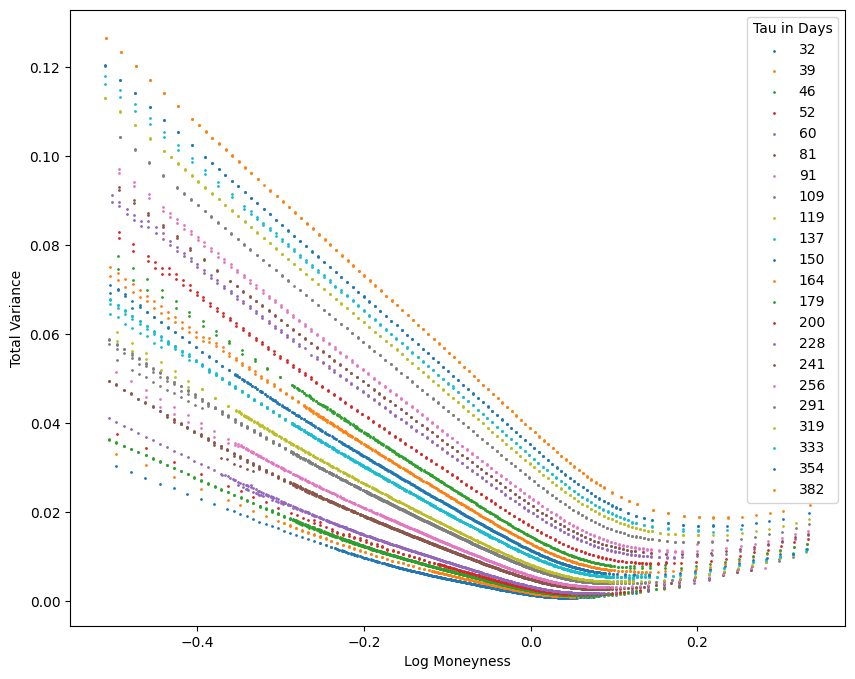

In [17]:
sample_plt = df_implied_vol.loc[df_implied_vol['tau_days'].between(30, 400) & df_implied_vol['moneyness'].between(0.6, 1.4)]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

for tau_days, group in sample_plt.groupby('tau_days'):
    ax.scatter(group['log_moneyness'], group['impl_vol_mid']**2 * group['tau_years'], s=1, label=tau_days)
    
ax.legend(title='Tau in Days', loc='upper right')
ax.set_xlabel('Log Moneyness')
ax.set_ylabel('Total Variance')

plt.show()

# 3.1.5 Surface Smoothing

$$m(k; p, h) = \mathbf{e}_1' (\mathbf{X}' \mathbf{W} \mathbf{X})^{-1} \mathbf{X}' \mathbf{W} \mathbf{Y}$$

$$
\mathbf{X} = 
\begin{pmatrix}
1 & k_1 - x & \cdots & (k_1 - k)^p \\
\vdots & \vdots & \ddots & \vdots \\
1 & k_n - k & \cdots & (k_n - k)^p
\end{pmatrix}_{\dim(\mathbf{k}) \times (p+1)}\text{,}
$$

$$
\mathbf{Y} = 
\begin{pmatrix}
\sigma^2_1 \\
\vdots \\
\sigma^2_n
\end{pmatrix}_{\dim(\mathbf{k}) \times 1}\text{, and}
$$

$$
\mathbf{W} = \operatorname{diag}(K_h(k_1 - k), \ldots, K_h(k_n - k))\text{ with}
$$

$$
K_h(z) = \frac{1}{h}\phi\left(\frac{z}{h}\right)\text{,}
$$

In [18]:
def K(z, h):
    z = z / h
    return np.exp(-0.5 * z**2) / np.sqrt(2 * np.pi)

In [19]:
def m_hat_p1(x, h, k_vec, sigma_squared_vec):
    diff_vec = k_vec - x
    X_mat = np.stack((np.ones(sigma_squared_vec.shape[0]), diff_vec), axis=1)
    W_mat = np.diag(K(diff_vec, h))
    Y_mat = np.reshape(sigma_squared_vec, (-1, 1))
    
    e_1 = np.zeros(2)
    e_1[0] = 1
    
    return e_1.T @ np.linalg.inv(X_mat.T @ W_mat @ X_mat) @ X_mat.T @ W_mat @ Y_mat

## Moneyness Domain

### Single Moneyness Slice

#### Constant Bandwidth

In [20]:
df_slice = df_implied_vol.loc[df_implied_vol['tau_days'] == 81]

In [21]:
k_vec = df_slice['log_moneyness'].values
sigma_squared_vec = np.square(df_slice['impl_vol_mid'].values)

In [22]:
# Bandwidths
h1 = 0.1
h2 = 0.005
h3 = 0.01

In [23]:
sigma_squared_smoothed_h1_vec = np.fromiter((m_hat_p1(log_m, h1, k_vec, sigma_squared_vec) for log_m in log_m_grid_vec), dtype=float)
sigma_squared_smoothed_h2_vec = np.fromiter((m_hat_p1(log_m, h2, k_vec, sigma_squared_vec) for log_m in log_m_grid_vec), dtype=float)
sigma_squared_smoothed_h3_vec = np.fromiter((m_hat_p1(log_m, h3, k_vec, sigma_squared_vec) for log_m in log_m_grid_vec), dtype=float)

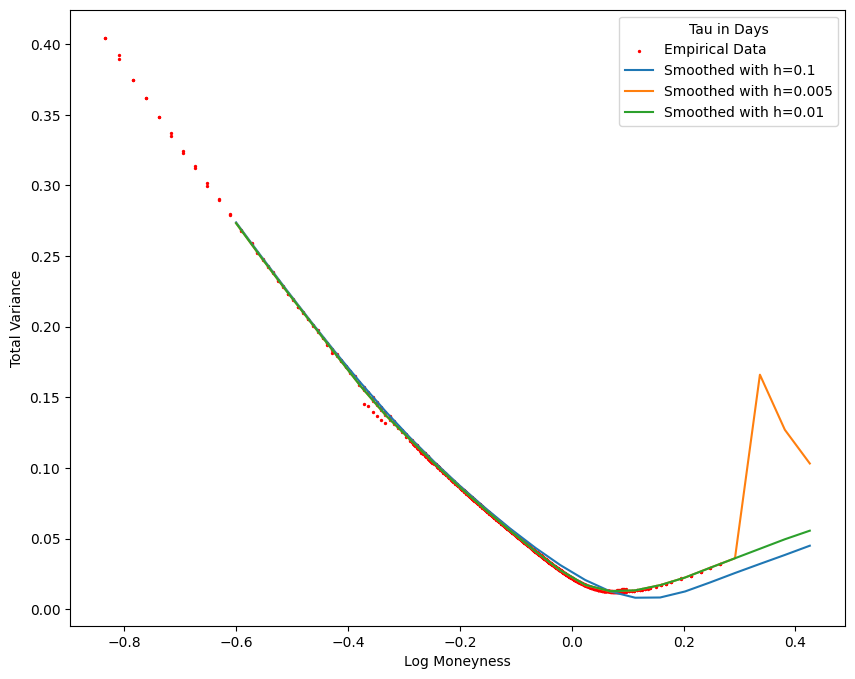

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(k_vec, sigma_squared_vec, label="Empirical Data", s=2, c='r')
ax.plot(log_m_grid_vec, sigma_squared_smoothed_h1_vec, label="Smoothed with h=0.1")
ax.plot(log_m_grid_vec, sigma_squared_smoothed_h2_vec, label="Smoothed with h=0.005")
ax.plot(log_m_grid_vec, sigma_squared_smoothed_h3_vec, label="Smoothed with h=0.01")
    
ax.legend(title='Tau in Days', loc='upper right')
ax.set_xlabel('Log Moneyness')
ax.set_ylabel('Total Variance')

plt.show()

#### KNN Bandwidth

$$h_{\lambda k_{\text{nn}}}(k) = \lambda \left|\mathbf{k}_{(k_{\text{nn}})}(k) - k\right|\text{,}$$

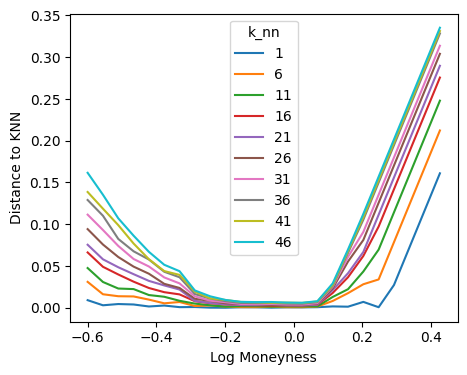

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4))

for k_nn in range(1, 50, 5):
    k_k_nn = np.fromiter((k_vec[np.argsort(np.abs(k_vec - k))[k_nn]] for k in log_m_grid_vec), dtype=float)
    dist_k_nn = np.abs(k_k_nn - log_m_grid_vec)
    ax.plot(log_m_grid_vec, dist_k_nn, label=k_nn)

ax.legend(title='k_nn')
ax.set_xlabel('Log Moneyness')
ax.set_ylabel('Distance to KNN')
plt.show()

In [26]:
k_nn = 10
h_lambda = 1

k_k_nn = np.fromiter((k_vec[np.argsort(np.abs(k_vec - k))[k_nn]] for k in k_vec), dtype=float)
dist_k_nn = np.abs(k_k_nn - k_vec)

h_vec = dist_k_nn * h_lambda

In [27]:
sigma_squared_smoothed_hknn_vec = np.fromiter((m_hat_p1(log_m, h_vec, k_vec, sigma_squared_vec) for log_m in log_m_grid_vec), dtype=float)

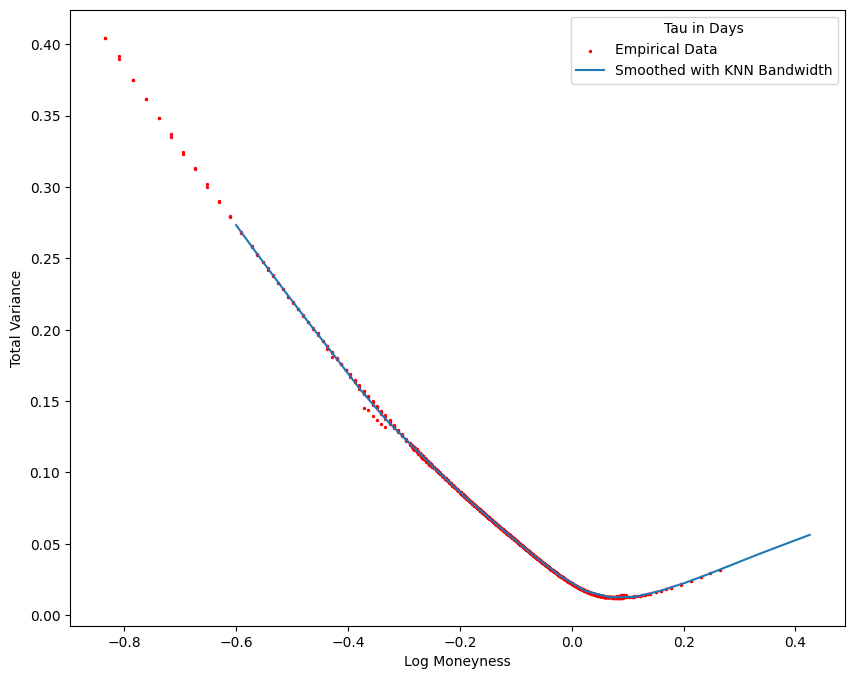

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

ax.scatter(k_vec, sigma_squared_vec, label="Empirical Data", s=2, c='r')
ax.plot(log_m_grid_vec, sigma_squared_smoothed_hknn_vec, label="Smoothed with KNN Bandwidth")
    
ax.legend(title='Tau in Days', loc='upper right')
ax.set_xlabel('Log Moneyness')
ax.set_ylabel('Total Variance')

plt.show()

#### Cross Validation

$$\min_{\lambda, k_{\text{nn}}} \frac{1}{\dim(\mathbf{k})} \sum_{i=1}^{\dim(\mathbf{k})} \left( \frac{\sigma^2_i - \hat{m}(k_i; p, h_{\lambda k_{\text{nn}}}(k))}{1 - W_{p,i}(k_i)} \right)^2 \quad \text{with} \; \lambda \in \mathbb{R}, k_{\text{nn}} \in \mathbb{Z}\text{.}$$

In [29]:
# Used to make a predict the value at k = k_vec[i]. Returns prediction and weight of empiricial data at k = k_vec[i].
def m_hat_p1_i(i, h, k_vec, sigma_squared_vec):
    k_dim = k_vec.shape[0]
    x = k_vec[i]
    diff_vec = k_vec - x
    X_mat = np.stack((np.ones(k_dim), diff_vec), axis=1)
    W_mat = np.diag(K(diff_vec, h))
    Y_mat = np.reshape(sigma_squared_vec, (-1, 1))
    
    e_1 = np.zeros(2)
    e_1[0] = 1
    
    m_hat_i = e_1.T @ np.linalg.inv(X_mat.T @ W_mat @ X_mat) @ X_mat.T @ W_mat @ Y_mat
    
    e_i = np.zeros(k_dim)
    e_i[i] = 1
    
    W_i = e_1.T @ np.linalg.inv(X_mat.T @ W_mat @ X_mat) @ X_mat.T @ W_mat @ e_i
    
    return [m_hat_i[0], W_i]

In [30]:
# Returns the MSE by predicting the empirical data based on a local linear regression that leaves the target data point out.
def cv_h_lambda_knn(h_lambda, h_knn, k_vec, sigma_squared_vec):
    
    try:
        k_k_nn = np.fromiter((k_vec[np.argsort(np.abs(k_vec - k))[h_knn]] for k in k_vec), dtype=float)
        dist_k_nn = np.abs(k_k_nn - k_vec)
        h_vec = dist_k_nn * h_lambda

        result_mat = np.array(list(m_hat_p1_i(i, h_vec, k_vec, sigma_squared_vec) for i in np.arange(k_vec.shape[0])))
        m_hat_i_vec = result_mat[:, :1]
        W_i_vec = result_mat[:, 1:]
        
        return np.average(np.square((sigma_squared_vec - m_hat_i_vec.reshape(-1) ) / (1 - W_i_vec)))
        
    except Exception as e:
        print(e)
        return np.nan

In [31]:
h_knn_vec = np.round(2 ** np.linspace(2, 6, 5)).astype(int)
h_lambda_vec = 2 ** np.linspace(-1, 1, h_knn_vec.shape[0])

h_knn_mesh, h_lambda_mesh = np.meshgrid(h_knn_vec, h_lambda_vec)
h_knn_mesh_vec = h_knn_mesh.reshape(-1)
h_lambda_mesh_vec = h_lambda_mesh.reshape(-1)

In [93]:
cv_scores_vec = np.fromiter((cv_h_lambda_knn(h_lambda_mesh_vec[i], h_knn_mesh_vec[i], k_vec, sigma_squared_vec) for i in range(h_knn_mesh_vec.shape[0])), dtype=float)

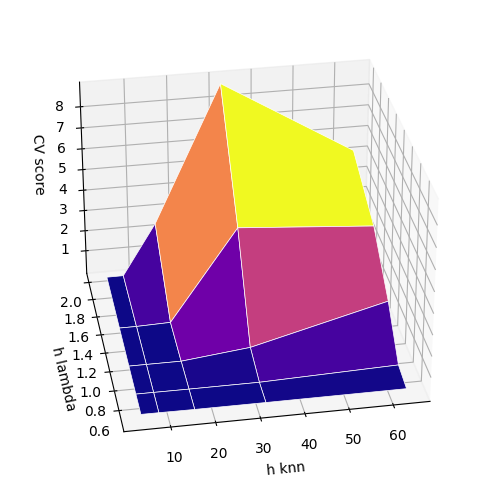

In [122]:
fig = plt.figure(figsize=(5, 5))
ax = fig.add_subplot(111, projection='3d')

surf = ax.plot_surface(h_knn_mesh, h_lambda_mesh, cv_scores_vec.reshape(h_knn_vec.shape[0], h_lambda_vec.shape[0]), cmap=cm.plasma, linewidths=0.5, edgecolor='white')

ax.set_xlabel('h knn', fontsize=10)
ax.set_ylabel('h lambda', fontsize=10)
ax.set_zlabel('CV score', fontsize=10)

ax.view_init(elev=30, azim=-100, roll=0)
plt.tight_layout()
plt.show()

### Every Moneyness Slice

In [32]:
def smooth_sigma_k(df_group, column):
    k_vec = df_group['log_moneyness'].values
    sigma_squared_vec = np.square(df_group[column].values)
    
    k_nn = 10
    h_lambda = 1
    k_k_nn = np.fromiter((k_vec[np.argsort(np.abs(k_vec - k))[k_nn]] for k in k_vec), dtype=float)
    dist_k_nn = np.abs(k_k_nn - k_vec)
    h_vec = dist_k_nn * h_lambda
    
    sigma_squared_hat = np.fromiter((m_hat_p1(log_m, h_vec, k_vec, sigma_squared_vec) for log_m in log_m_grid_vec), dtype=float)
    return np.sqrt(sigma_squared_hat)

In [33]:
tau_days_list = []
sigma_hat_list = []

for tau_days, df_group in df_implied_vol.loc[df_implied_vol['tau_days'].between(17, 593)].groupby('tau_days'):
    try:
        smooth_sigma_bid_vec = smooth_sigma_k(df_group, column='impl_vol_bid')
        smooth_sigma_mid_vec = smooth_sigma_k(df_group, column='impl_vol_mid')
        smooth_sigma_ask_vec = smooth_sigma_k(df_group, column='impl_vol_offer')
        smooth_sigma_full_vec = np.stack([smooth_sigma_bid_vec, smooth_sigma_mid_vec, smooth_sigma_ask_vec], axis=1)
        if not np.isnan(smooth_sigma_full_vec).reshape(-1).any():
            sigma_hat_list.append(smooth_sigma_full_vec)
            tau_days_list.append(tau_days)
            
    except Exception as e:
        print(e)
        pass

tau_days_vec = np.array(tau_days_list)
log_tau_years_vec = np.log(tau_days_vec/365)
sigma_hat_mat = np.stack(sigma_hat_list)

/var/folders/r0/l1q6kw3908j551blj1nklmn40000gn/T/ipykernel_41601/1712634376.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(sigma_squared_hat)


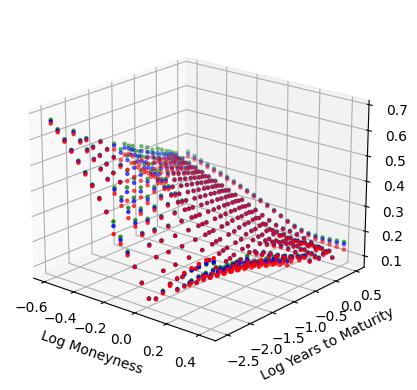

In [34]:
fig = plt.figure(figsize=(6.3, 4))

X, Y = np.meshgrid(log_m_grid_vec, log_tau_years_vec)
Z_bid = sigma_hat_mat[:, :, 0].reshape(-1)
Z_mid = sigma_hat_mat[:, :, 1].reshape(-1)
Z_offer = sigma_hat_mat[:, :, 2].reshape(-1)

ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(X, Y, Z_bid, c='r', s=5)
surf = ax.scatter(X, Y, Z_mid, c='b', s=5)
surf = ax.scatter(X, Y, Z_offer, c='g', s=5)


ax.set_xlabel('Log Moneyness', fontsize=10)
ax.set_ylabel('Log Years to Maturity', fontsize=10)

ax.view_init(elev=20, azim=-50, roll=0)
plt.tight_layout()
plt.show()

## Maturity Domain

In [35]:
sigma_vec = sigma_hat_mat[:, 0, 0]

In [36]:
sigma_hat_tau_list = []

for i in range(sigma_hat_mat.shape[1]):
    smooth_sigma_bid_vec = np.fromiter((m_hat_p1(log_tau, 0.2, log_tau_years_vec, sigma_hat_mat[:, i, 0]) for log_tau in log_tau_grid_vec), dtype=float)
    smooth_sigma_mid_vec = np.fromiter((m_hat_p1(log_tau, 0.2, log_tau_years_vec, sigma_hat_mat[:, i, 1]) for log_tau in log_tau_grid_vec), dtype=float)
    smooth_sigma_offer_vec = np.fromiter((m_hat_p1(log_tau, 0.2, log_tau_years_vec, sigma_hat_mat[:, i, 2]) for log_tau in log_tau_grid_vec), dtype=float)
    smooth_sigma_full_vec = np.stack([smooth_sigma_bid_vec, smooth_sigma_mid_vec, smooth_sigma_offer_vec], axis=1)
    sigma_hat_tau_list.append(smooth_sigma_full_vec)
    
sigma_hat_tau_mat = np.stack(sigma_hat_tau_list)

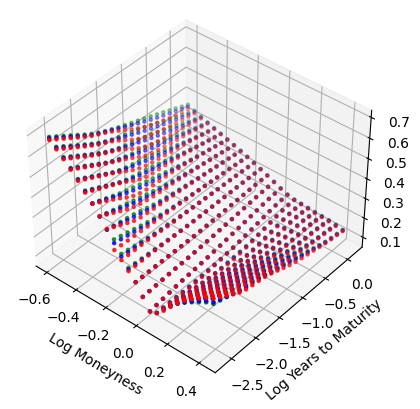

In [37]:
fig = plt.figure(figsize=(6.3, 4))

X, Y = np.meshgrid(log_m_grid_vec, log_tau_grid_vec)
Z_bid = sigma_hat_tau_mat[:, :, 0].T
Z_mid = sigma_hat_tau_mat[:, :, 1].T
Z_offer = sigma_hat_tau_mat[:, :, 2].T

ax = fig.add_subplot(111, projection='3d')
surf = ax.scatter(X, Y, Z_bid, c='r', s=5)
surf = ax.scatter(X, Y, Z_mid, c='b', s=5)
surf = ax.scatter(X, Y, Z_offer, c='g', s=5)


ax.set_xlabel('Log Moneyness', fontsize=10)
ax.set_ylabel('Log Years to Maturity', fontsize=10)

ax.view_init(elev=40, azim=-50, roll=0)
plt.tight_layout()
plt.show()

# 3.1.6 Static Arbitrage Repair

In [42]:
# Legacy adoption
log_m_grid_mat, log_tau_grid_mat = np.meshgrid(log_m_grid_vec, log_tau_grid_vec)

m = log_m_grid_mat.T.reshape(-1)
tau = log_tau_grid_mat.T.reshape(-1)

# Tatal volaility mid
v_bid = sigma_hat_tau_mat[:, :, 0].reshape(-1) * np.sqrt(np.exp(tau))
v = sigma_hat_tau_mat[:, :, 1].reshape(-1) * np.sqrt(np.exp(tau))
v_offer = sigma_hat_tau_mat[:, :, 2].reshape(-1) * np.sqrt(np.exp(tau))

tau_mat = np.reshape(tau, (m_n_points + 4, tau_n_points + 2))
m_mat = np.reshape(m, (m_n_points + 4, tau_n_points + 2))
v_bid_mat = np.reshape(v_bid, (m_n_points + 4, tau_n_points + 2))
v_mat = np.reshape(v, (m_n_points + 4, tau_n_points + 2))
v_offer_mat = np.reshape(v_offer, (m_n_points + 4, tau_n_points + 2))

grid_mat_idx = (slice(2,-2), slice(1,-1))

In [43]:
# Manipulation
v[100] = v[100]-.02
v[101] = v[101]-.03
v[102] = v[102]-.02

### Positivity Constraint

(Positivity) $\Sigma(k, \tau) > 0$, $\; \forall \; k, \tau > 0$.

In [44]:
def loss_pos(e):
    v_alt_mat_trunc = v_mat[grid_mat_idx] + np.reshape(e, (m_n_points, tau_n_points))
    l_pos = (-v_alt_mat_trunc).clip(0, None)
    return l_pos

### Calendar Constraint

(Monotonicity in $\tau$) $\Sigma(k, \cdot)$ is non-decreasing, $\; \forall \; k$.

In [45]:
tau_vec = tau_mat[0, :]
v_mat
def loss_cal(e):
    v_alt_mat = v_mat.copy()
    v_alt_mat[grid_mat_idx] = v_alt_mat[grid_mat_idx] + np.reshape(e, (m_n_points, tau_n_points))
    v_alt_diff_1_trunc = np.gradient(v_alt_mat, tau_vec, axis=1)[grid_mat_idx]
    l_cal = (-v_alt_diff_1_trunc).clip(0, None)
    return l_cal

### Butterfly Constraint

(Durrleman’s Condition) $\; \forall \; k, \tau > 0\text{:}$

$$
0 \le \left( 1 - \frac{k \, \partial_k \Sigma(k, \tau)}{\Sigma(k, \tau)} \right)^2 - \frac{1}{4} \Sigma(k, \tau)^2 (\partial_k \Sigma(k, \tau))^2 + \Sigma(k, \tau) \, \partial_{kk}^2 \Sigma(k, \tau)\text{.}
$$

In [63]:
m_vec = m_mat[:, 0]
m_mat_trunc = m_mat[grid_mat_idx]

def loss_but(e):
    v_alt_mat = v_mat.copy()
    v_alt_mat[grid_mat_idx] = v_alt_mat[grid_mat_idx] + np.reshape(e, (m_n_points, tau_n_points))
    v_alt_mat_trunc = v_alt_mat[grid_mat_idx]
    v_alt_diff_1 = np.gradient(v_alt_mat, m_vec, axis=0)
    v_alt_diff_1_trunc = v_alt_diff_1[grid_mat_idx]
    v_alt_diff_2_trunc = np.gradient(v_alt_diff_1, m_vec, axis=0)[grid_mat_idx]
    durrleman_value = (1 - m_mat_trunc * v_alt_diff_1_trunc / v_alt_mat_trunc )**2 - v_alt_mat_trunc **2 * v_alt_diff_1_trunc**2 / 4 + v_alt_mat_trunc * v_alt_diff_2_trunc
    l_but = (-durrleman_value).clip(0, None)
    return l_but

### Objective Function

$$
\begin{split}
    \ell_{c} (\boldsymbol{\delta}; \delta_{\text{bid}}, \delta_{\text{ask}}) =& \frac{-\delta_{\text{bid}}}{2}\left(\frac{\boldsymbol{\delta}^{+}_{\text{in spread}}}{\delta_{\text{bid}}}\right)^2    +     \frac{-\delta_{\text{ask}}}{2}\left(\frac{\boldsymbol{\delta}^{-}_{\text{in spread}}}{\delta_{\text{ask}}}\right)^2     \\
    &+    \left| \boldsymbol{\delta}^{-}_{\text{outside spread}} - \delta_{\text{bid}} \right|  +  \left| \boldsymbol{\delta}^{+}_{\text{outside spread}} - \delta_{\text{ask}} \right|\text{, with} \\
\end{split}
$$

$$
\begin{split}
    \boldsymbol{\delta}^{+}_{\text{in spread}} &= \max(0, \min(\delta_{\text{bid}}, \boldsymbol{\delta}))\text{,}\\
    \boldsymbol{\delta}^{-}_{\text{in spread}} &= \max(\delta_{\text{ask}}, \min(0, \boldsymbol{\delta})\text{,})\\
    \boldsymbol{\delta}^{+}_{\text{outside spread}} &= \max(\delta_{\text{bid}}, \boldsymbol{\delta})\text{, and}\\
    \boldsymbol{\delta}^{-}_{\text{outside spread}} &= \min(\delta_{\text{ask}}, \boldsymbol{\delta})\text{.}
\end{split}
$$

In [61]:
d_b = np.clip(v_bid_mat[grid_mat_idx] - v_mat[grid_mat_idx], None, -.001)
d_a = np.clip(v_offer_mat[grid_mat_idx] - v_mat[grid_mat_idx], 0.001, None)

def obj_func(e):
    d = np.reshape(e, (m_n_points, tau_n_points))
    
    below_in_spread = np.clip(d, d_b, 0)
    above_in_spread = np.clip(d, 0, d_a)
    below_spread = np.abs(np.clip(d, None, d_b)-d_b)
    above_spread = np.abs(np.clip(d, d_a, None)-d_a)
    loss_mat = below_spread + above_spread + np.square(above_in_spread/d_a)*d_a/2 + np.square(below_in_spread/d_b)*-d_b/2
    
    return np.sum(np.abs(loss_mat))/10000

### Constraints

In [49]:
pos_constraint = NonlinearConstraint(lambda x: np.sum(loss_pos(x)), -np.inf, 0)
cal_constraint = NonlinearConstraint(lambda x: np.sum(loss_cal(x)), -np.inf, 0)
but_constraint = NonlinearConstraint(lambda x: np.sum(loss_but(x)), -np.inf, 0)

### Optimization

$$    \min_{\boldsymbol{\delta}} \ell_{c} (\boldsymbol{\delta}; \delta_{\text{bid}}, \delta_{\text{ask}}) \quad \text{s.t.} \; \ell_{\text{ICV}}(\boldsymbol{\delta}) = 0$$

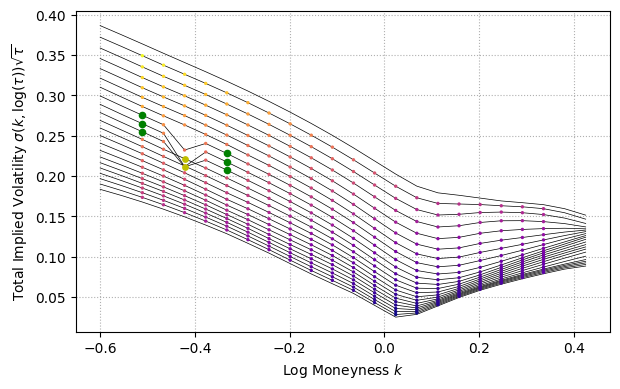

In [50]:
# Before Repair
fig, ax = plt.subplots(1, 1, figsize=(6.3, 4))

# Line Plot
for i in range(tau_mat.shape[1]):
    ax.plot(m_mat[:, i], v_mat[:, i], label=f'{np.exp(tau_mat[0, i]):.2f}', zorder=1, lw=0.5, c='black')
    
# Scatter Grid
ax.scatter(m_mat[grid_mat_idx], v_mat[grid_mat_idx], s=2, zorder=2, c=v_mat[grid_mat_idx], cmap=cm.plasma)

# Positivity
loss_pos_index = np.where(loss_pos(np.zeros(400)) > 0)
ax.scatter(m_mat[grid_mat_idx][loss_pos_index], v_mat[grid_mat_idx][loss_pos_index], s=10, zorder=5, c='r')

# Calendar
loss_cal_index = np.where(loss_cal(np.zeros(400)) > 0)
ax.scatter(m_mat[grid_mat_idx][loss_cal_index], v_mat[grid_mat_idx][loss_cal_index], s=15, zorder=4, c='y')


loss_but_index = np.where(loss_but(np.zeros(400)) > 0)
ax.scatter(m_mat[grid_mat_idx][loss_but_index], v_mat[grid_mat_idx][loss_but_index], s=20, zorder=3, c='g')

ax.grid(linestyle='dotted')
ax.set_axisbelow(True)

ax.set_xlabel('Log Moneyness $k$', fontsize=10)
ax.set_ylabel(r'Total Implied Volatility $\sigma(k, \log(\tau))\sqrt{\tau}$', fontsize=10)

fig.tight_layout()
plt.show()

In [51]:
e_init = np.zeros(400)

In [54]:
# Before
print(f'Loss Positivity   : {np.sum(loss_pos(e_init)):.10f}; No of Violations: {np.sum(loss_pos(e_init) > 0)}')
print(f'Loss Calendar     : {np.sum(loss_cal(e_init)):.10f}; No of Violations: {np.sum(loss_cal(e_init) > 0)}')
print(f'Loss Butterfly    : {np.sum(loss_but(e_init)):.10f}; No of Violations: {np.sum(loss_but(e_init) > 0)}')
print(f'---')
print(f'Objective Function: {obj_func(e_init):.10f}')

Loss Positivity   : 0.0000000000; No of Violations: 0
Loss Calendar     : 0.0423521558; No of Violations: 2
Loss Butterfly    : 2.6515145922; No of Violations: 6
---
Objective Function: 0.0000000000


In [55]:
result = minimize(obj_func, e_init, constraints=(pos_constraint, cal_constraint, but_constraint), tol=0.000001, method='SLSQP', options={"disp": True, "maxiter": 500})

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.544385521534779e-07
            Iterations: 103
            Function evaluations: 41434
            Gradient evaluations: 103


In [56]:
e_hat = result.x.copy()

In [58]:
# Before
print(f'Loss Positivity   : {np.sum(loss_pos(e_hat)):.10f}; No of Violations: {np.sum(loss_pos(e_hat) > 0)}')
print(f'Loss Calendar     : {np.sum(loss_cal(e_hat)):.10f}; No of Violations: {np.sum(loss_cal(e_hat) > 0)}')
print(f'Loss Butterfly    : {np.sum(loss_but(e_hat)):.10f}; No of Violations: {np.sum(loss_but(e_hat) > 0)}')
print(f'---')
print(f'Objective Function: {obj_func(e_hat):.10f}')

Loss Positivity   : 0.0000000000; No of Violations: 0
Loss Calendar     : 0.0000000000; No of Violations: 0
Loss Butterfly    : 0.0000000000; No of Violations: 0
---
Objective Function: 0.0000006544


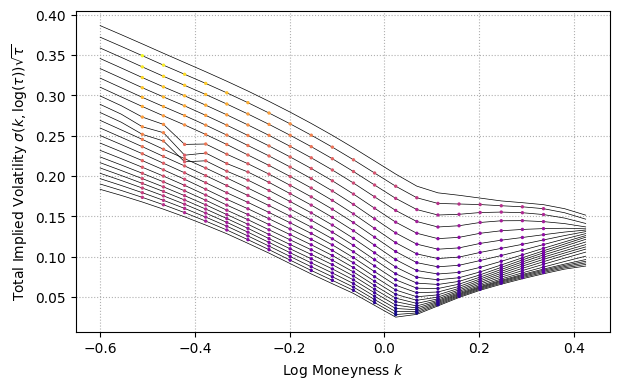

In [59]:
# After Repair

v_mat_alt = v_mat.copy()
v_mat_alt[grid_mat_idx] = v_mat_alt[grid_mat_idx] + np.reshape(e_hat, (m_n_points, tau_n_points))

fig, ax = plt.subplots(1, 1, figsize=(6.3, 4))

# Line Plot
for i in range(tau_mat.shape[1]):
    ax.plot(m_mat[:, i], v_mat_alt[:, i], label=f'{np.exp(tau_mat[0, i]):.2f}', zorder=1, lw=0.5, c='black')
    
# Scatter Grid
ax.scatter(m_mat[grid_mat_idx], v_mat_alt[grid_mat_idx], s=2, zorder=2, c=v_mat[grid_mat_idx], cmap=cm.plasma)

# Positivity
loss_pos_index = np.where(loss_pos(e_hat) > 0)
ax.scatter(m_mat[grid_mat_idx][loss_pos_index], v_mat_alt[grid_mat_idx][loss_pos_index], s=10, zorder=5, c='r')

# Calendar
loss_cal_index = np.where(loss_cal(e_hat) > 0)
ax.scatter(m_mat[grid_mat_idx][loss_cal_index], v_mat_alt[grid_mat_idx][loss_cal_index], s=15, zorder=4, c='y')

# Butterfly
loss_but_index = np.where(loss_but(e_hat) > 0)
ax.scatter(m_mat[grid_mat_idx][loss_but_index], v_mat_alt[grid_mat_idx][loss_but_index], s=20, zorder=3, c='g')

ax.grid(linestyle='dotted')
ax.set_axisbelow(True)

ax.set_xlabel('Log Moneyness $k$', fontsize=10)
ax.set_ylabel(r'Total Implied Volatility $\sigma(k, \log(\tau))\sqrt{\tau}$', fontsize=10)

fig.tight_layout()
plt.show()